# Interpolation

- Polynomials are typically used.
  $$p(x) = y_i + (x - x_i)\left( \dfrac{y_{i+1} - y_i}{x_{i+1} - x_i}\right) + \mathcal{O}(\Delta x^2)$$
  
    - Linear Approximation $\rightarrow$ second-order error. Second derivatives discontinuous.
    - Quadratic approximation $\rightarrow$ third-order error. Third derivatives discontinuous.
- Lagrange's method
  $$p(x) = \sum_{j=1}^{j=N} \left[ y_j \prod_{i=1, \text{ } i\neq j}^{i=N} \left( \dfrac{x - x_i}{x_j - x_i} \right) \right]$$
  Defines an approximation which is of order N, and goes through *all* N points.

In [1]:
# Imports and Auxiliary function definitions

import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.divide(1, 25 * np.power(x, 2) + 1)

def interval(N):
    return np.linspace(-1, 1, N)

In [2]:
# A function to do Lagrange Interpolation at every point

def linterp(fvals, xvals, x):
    s = 0 # sum
    for j in range(len(fvals)):
        p = 1 # prod
        for i in range(len(xvals)):
            if i != j:
                p *= (x - xvals[i])/(xvals[j] - xvals[i])
        p *= fvals[j]
        s += p
    return s

In [3]:
# Defining intervals and interpolating over them

x1 = interval(3)
x2 = interval(5)
x3 = interval(10)

x = interval(100) # this is a reference interval

interpolate_values1 = np.array([linterp(f(x1), x1, k) for k in x])
interpolate_values2 = np.array([linterp(f(x2), x2, k) for k in x])
interpolate_values3 = np.array([linterp(f(x3), x3, k) for k in x])

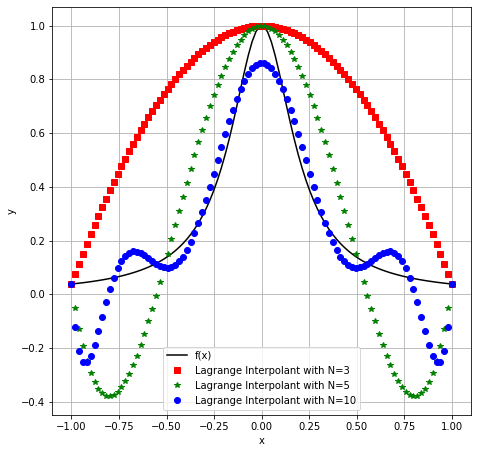

In [4]:
fig = plt.figure()
fig.set_size_inches(7.5, 7.5)
plt.plot(x, f(x), 'k', label='f(x)')
plt.plot(x, interpolate_values1, 'rs', label='Lagrange Interpolant with N=3')
plt.plot(x, interpolate_values2, 'g*', label='Lagrange Interpolant with N=5')
plt.plot(x, interpolate_values3, 'bo', label='Lagrange Interpolant with N=10')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.legend()

### Observations : 

- The more the order of the interpolating polynomial, the better it fits the points.
- However, as the order increases, the amount of oscillations also increases $\Rightarrow$ overfitting can occur.

An improvement over this fitting is to use **cubic splines**, which is a 3rd order polynomial fit locally such that there are some nice global properties. We fit these such that:

- The functions over each interval are smooth and continuous. This is to avoid oscillations.
- We ensure continuity of function at the data points, and also continuity upto the 3rd derivative.

# Cubic Splines
Say we have 'm' intervals. The we fit a cubic spline in each interval as:
    $$p_j(x) = a_j(x-x_j)^3 + b_j(x-x_j)^2 + c_j(x-x_j) + d_j \quad (0 \leq j \leq m)$$
Now, we need to determine 4m coefficients. But applying the smoothness conditions, some of the coefficients are constrained. In fact, 4m - 2 coefficients are constrained. For fixing the remaining 2, we must set the values of the derivatives at the end points.

In our case, we set these to 0. Such cubic splines are called **natural splines**.

### Fitting the Spline
- From the data points $\rightarrow p_j(x_j) = y_j \Rightarrow \boxed{d_j = y_j}\quad$ (m conditions)
- From the last data points $\rightarrow p_m(x_{m+1}) = y_{m+1}\quad$ (1 condition)
- From the smoothness conditions $\rightarrow p^{(0,1,2)}_j(x_{j+1}) = p^{(0,1,2)}_{j+1}(x_{j+1})\quad$ ($3(m-1)$ conditions)

Thus, we are short by $4m - (4m-2) = 2$ conditions.
To fix these two as well, we set $p_1^{\prime\prime}(x_1) = p_m^{\prime\prime}(x_{m+1}) = 0$, and bring every coefficient other than $d_j$ in terms of the second derivative.

- For $b_j$: we see that $p_j^{\prime\prime}(x_j) = 2b_j \Rightarrow \boxed{b_j = \dfrac{p_j^{\prime\prime}(x_j)}{2}}$.
- For $a_j$: we see that at $x = x_{j+1}$, $p_j^{\prime\prime}(x_{j+1}) = 6a_jh_j + 2 b_j \Rightarrow \boxed{a_j = \dfrac{1}{6}\left[ \dfrac{p_j^{\prime\prime}(x_{j+1}) - p_j^{\prime\prime}(x_j)}{h_j}\right]}$
- For $c_j$: we see that $p_j(x_{j+1}) = a_j h_j^3 + b_j h_j^2 + c_j h_j + d_j \Rightarrow \boxed{c_j = \dfrac{p_j(x_{j+1}) - p_j(x_j)}{h_j} - \dfrac{h_jp_j^{\prime\prime}(x_{j+1}) + 2h_jp_j^{\prime\prime}(x_j)}{6}}$

For getting the $p_j^{\prime\prime}(x_j)$ values in terms of the $p_j(x_j)$, we will use the first derivatives and their continuity, which leads to a set of tridiagonal linear equations, where we will have :
   - $b_j$ on the main diagonal, where $1 \leq j \leq n$
   - $a_j$ on the lower sub-diagonal, where $2 \leq j \leq n$
   - $c_j$ on the upper sub-diagonal, where $1 \leq j \leq n-1$
   
We will also have the column vector of variables, and a column vector for the constants $\vec{r}$.

To solve this matrix, we simply need to apply Gaussian Elimination to it, but with a twist. First, once the $a_2$ is eliminated in the second row, we rename the new $b_2$ (along with whatever subtraction factors) as $\beta_2$ and similarly with $r_2$, renamed to $\rho_2$. Then, we get the following recurrences :
- $\beta_j = b_j - \dfrac{a_j}{\beta_{j-1}}\cdot c_{j-1}\quad(2\leq j \leq n)$
- $\rho_j = r_j - \dfrac{a_j}{\beta_{j-1}}\cdot r_{j-1}\quad(2\leq j \leq n)$
After $n-1$ such steps, the last equation becomes $\beta_n x_n = \rho_n$, from which we can solve for $x_n$ and back-substitute.
$$x_{n-j} = \dfrac{\rho_{n-j} - c_{n-j}x_{n-j+1}}{\beta_{n-j}}; \quad 1 \leq j \leq (n-1)$$

Now, from the four arrays for the a's, b's, c's and r's, we need to define the $\beta$ and $\rho$ arrays.